pyLigthGBM
=======

Python wrapper for Microsoft [LightGBM](https://github.com/Microsoft/LightGBM)  
Make sure that you have installed LightGBM [Installation-Guide](https://github.com/Microsoft/LightGBM/wiki/Installation-Guide)

**GitHub      :  [https://github.com/ArdalanM/pyLightGBM](https://github.com/ArdalanM/pyLightGBM) **

**Author of this notebook :** Evgeny BAZAROV <baz.evgenii@gmail.com>

-------


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import os, gc
import numpy as np
import pandas as pd

from sklearn import metrics, model_selection
from sklearn.preprocessing import LabelEncoder

from pylightgbm.models import GBMRegressor

DATA
-------

For this example used **data from Kaggle competition Allstate Claims Severity**  
You can download data here : https://www.kaggle.com/c/allstate-claims-severity/data

In [2]:
df_train = pd.read_csv("data/train.csv.zip")
print('Train data shape', df_train.shape)

df_test = pd.read_csv("data/test.csv.zip")
print('Test data shape', df_test.shape)

Train data shape (188318, 132)
Test data shape (125546, 131)


Extracting `loss` from train and `id` from test

In [3]:
y = np.log(df_train['loss']+1).as_matrix().astype(np.float)
id_test = np.array(df_test['id'])

Merging train and test data

In [4]:
df = df_train.append(df_test, ignore_index=True)
del df_test, df_train
gc.collect()

print('Merged data shape', df.shape)

Merged data shape (313864, 132)


Droping not useful columns

In [5]:
df.drop(labels=['loss', 'id'], axis=1, inplace=True)
feature_list = df.columns.tolist()

Transfrom categorical features `cat` from 1 to 116

In [6]:
le = LabelEncoder()

for col in df.columns.tolist():
    if 'cat' in col:
        df[col] = le.fit_transform(df[col])

TRAIN, VALIDATION, TEST
-------
Split data into train, validation (for early stopping) and test set

In [7]:
print('train-test split')
df_train, df_test = df.iloc[:len(y)], df.iloc[len(y):]
del df
gc.collect()

print('train-validation split\n')
X = df_train.as_matrix()
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)
X_test = df_test.as_matrix()

del df_train, df_test
gc.collect()

print('Train shape', X_train.shape)
print('Validation shape', X_valid.shape)
print('Test shape', X_test.shape)

train-test split
train-validation split

Train shape (150654, 130)
Validation shape (37664, 130)
Test shape (125546, 130)


TRAINING GBMRegressor
-------
List of parameters and their explanation you can find here https://github.com/Microsoft/LightGBM/wiki/Quick-Start

**don't forget to change `exec_path` here**

In [8]:
seed = 42

gbmr = GBMRegressor(
    exec_path='/path/to/your/LightGBM/lightgbm', # change this to your LighGBM path
    config='',
    application='regression',
    num_iterations=500,
    learning_rate=0.1,
    num_leaves=10,
    tree_learner='serial',
    num_threads=4,
    min_data_in_leaf=10,
    metric='l2',
    feature_fraction=1.0,
    feature_fraction_seed=seed,
    bagging_fraction=1.0,
    bagging_freq=0,
    bagging_seed=seed,
    metric_freq=1,
    early_stopping_round=10
)

gbmr.fit(X_train, y_train, test_data=[(X_valid, y_valid)])
print("Mean Square Error:", metrics.mean_absolute_error(y_true=(np.exp(y_valid)-1), y_pred=(np.exp(gbmr.predict(X_valid))-1)))

[LightGBM] finished load parameters
[LightGBM] Finish loading data, use 0.711743 seconds 
[LightGBM] #data:150654 #feature:130

[LightGBM] finish training init
[LightGBM] start train
[LightGBM] Iteration:1, /tmp/tmphwxvp02b/X0_test.svm's l2 loss : 6.961980
[LightGBM] 0.021856 seconds elapsed, finished 1 iteration
[LightGBM] Iteration:2, /tmp/tmphwxvp02b/X0_test.svm's l2 loss : 6.272212
[LightGBM] 0.043370 seconds elapsed, finished 2 iteration
[LightGBM] Iteration:3, /tmp/tmphwxvp02b/X0_test.svm's l2 loss : 5.652135
[LightGBM] 0.065526 seconds elapsed, finished 3 iteration
[LightGBM] Iteration:4, /tmp/tmphwxvp02b/X0_test.svm's l2 loss : 5.094611
[LightGBM] 0.090001 seconds elapsed, finished 4 iteration
[LightGBM] Iteration:5, /tmp/tmphwxvp02b/X0_test.svm's l2 loss : 4.593778
[LightGBM] 0.286686 seconds elapsed, finished 5 iteration
[LightGBM] Iteration:6, /tmp/tmphwxvp02b/X0_test.svm's l2 loss : 4.143739
[LightGBM] 0.348910 seconds elapsed, finished 6 iteration
[LightGBM] Iteration:7, /

In [9]:
print('Best round', gbmr.best_round)

Best round 500


FEATURE IMPORTANCE
-------
TOP 10

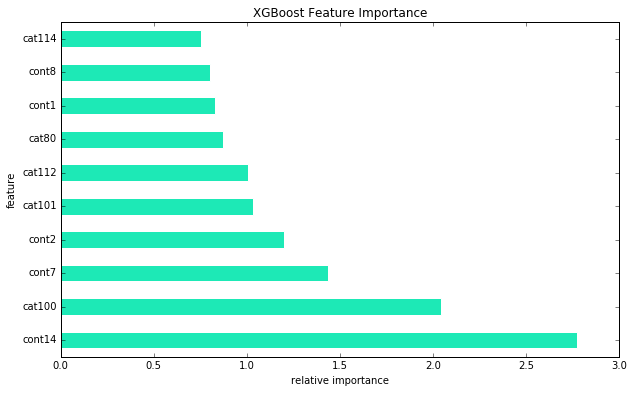

In [10]:
feature_dict = dict(zip(range(len(feature_list)), feature_list))
df_fi = pd.DataFrame(gbmr.feature_importance(), columns=['feature', 'importance'])
df_fi = df_fi.replace({"feature": feature_dict})

del feature_dict, feature_list

top = 10

plt.figure()
df_fi.head(top).plot(kind='barh',
                     x='feature',
                     y='importance',
                     sort_columns=False,
                     legend=False,
                     figsize=(10, 6),
                     facecolor='#1DE9B6',
                     edgecolor='white')

plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')

SUBMISSION
-------
Predicting Test set

In [11]:
y_test_preds = gbmr.predict(X_test)
y_test_preds=(np.exp(y_test_preds)-1)

[LightGBM] finished load parameters
[LightGBM] Loaded 500 modles

[LightGBM] finish predict init
[LightGBM] start prediction for data /tmp/tmp35nwyz05/X_to_pred.svm, and data has label
[LightGBM] finish predict



Make submission file

In [12]:
df_submission = pd.read_csv('data/sample_submission.csv.zip')
df_submission['loss'] = y_test_preds

Save submission file

In [13]:
df_submission.to_csv('submission.csv',index=False)

#### This submission file scored 1138.06444 on LB